In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_clean_A1 import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

# SETUP

In [10]:
# environment hyperparams
#option 1 :  use n_updates to define n_steps
n_updates = 100000
n_envs = 1
n_steps_per_update = 1
n_steps = n_envs * n_steps_per_update * n_updates

#option 2 :  use n_steps to define n_updates
#n_steps = 500000
#n_updates = n_steps // (n_envs * n_steps_per_update) # number of updates

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
#envs = gym.vector.make("CartPole-v1", num_envs=n_envs)
env = gym.make("CartPole-v1")

obs_shape = env.observation_space.shape[0]
print(obs_shape)
action_shape = env.action_space.n
print(action_shape)
# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("using cuda")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs = 1)

4
2


In [11]:
# LOGGED VARIABLES
critic_losses = []
actor_losses = []
ep_rewards = []
entropies = []
steps_episodes = [] # logs the steps taken in each episode
# COUNTERS
steps_counter = 0
ep_counter = 0
ep_reward = 0
# VARIABLE INITIALIZATION
is_truncated = False
is_terminated = False
state, info = env.reset(seed=42)

# TRAINING LOOP (using n_steps as the number of steps to train for)
for sample_phase in tqdm(range(n_steps)):
    
    if is_truncated == True or is_terminated == True:
        state,info = env.reset(seed=42)
        is_truncated = False
        is_terminated = False
        ep_counter += 1
        steps_episodes.append(steps_counter)
        ep_rewards.append(ep_reward)
        ep_reward = 0



    #collect experiences for a step
    
    action, action_log_prob, Vs_t1, entropy = agent.select_action(state, bool_greedy=False)
    with torch.no_grad():
        state, reward, is_terminated,is_truncated, info = env.step(action.numpy())
        steps_counter += 1
        ep_reward += reward
        mask = not is_terminated
    
    #calculate loss
    critic_loss, actor_loss = agent.get_losses(
        reward,
        action_log_prob,
        Vs_t1,
        entropy,
        mask,
        gamma,
        torch.tensor(state),
    )
    

    #update agent 
    agent.update_parameters(critic_loss, actor_loss)


    #log data
    critic_losses.append(critic_loss.detach().numpy()) #detach for plotting later, need to detach
    actor_losses.append(actor_loss.detach().numpy())
    entropies.append(entropy)
    
    
       

        


100%|██████████| 100000/100000 [03:15<00:00, 512.61it/s]


In [48]:
#save agent critic and actor weights
torch.save({
    'actor_state_dict': agent.actor.state_dict(),
    'critic_state_dict': agent.critic.state_dict(),
    'actor_optimizer_state_dict': agent.actor_optim.state_dict(),
    'critic_optimizer_state_dict': agent.critic_optim.state_dict(),
}, 'agent1_weights.pth')



In [ ]:
checkpoint = torch.load('model_checkpoint.pth')
agent.actor.load_state_dict(checkpoint['actor_state_dict'])
agent.critic.load_state_dict(checkpoint['critic_state_dict'])
agent.actor_optim.load_state_dict(checkpoint['actor_optimizer_state_dict'])
agent.critic_optim.load_state_dict(checkpoint['critic_optimizer_state_dict'])


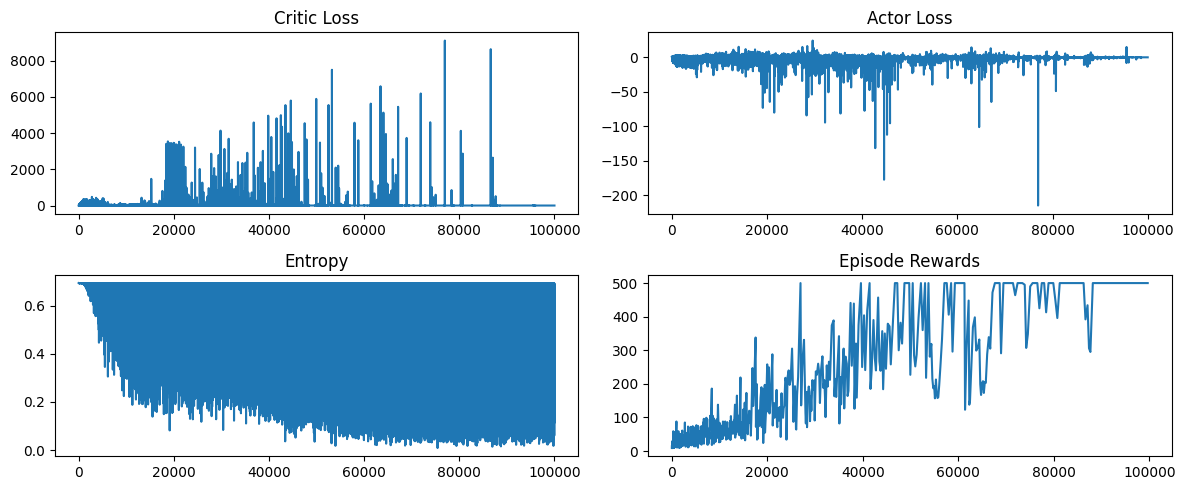

In [20]:
# ICI CEST 10K + 20K steps apres les 500k steps, il reste stable
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
critic_losses = np.array(critic_losses)
capped_loss = critic_losses[critic_losses < 1]
axs[0, 0].plot(critic_losses)
axs[0, 0].set_title('Critic Loss')
axs[0, 1].plot(actor_losses)
axs[0, 1].set_title('Actor Loss')
axs[1, 0].plot(entropies)
axs[1, 0].set_title('Entropy')
axs[1, 1].plot(steps_episodes, ep_rewards)
axs[1, 1].set_title('Episode Rewards')
plt.tight_layout()
plt.show()


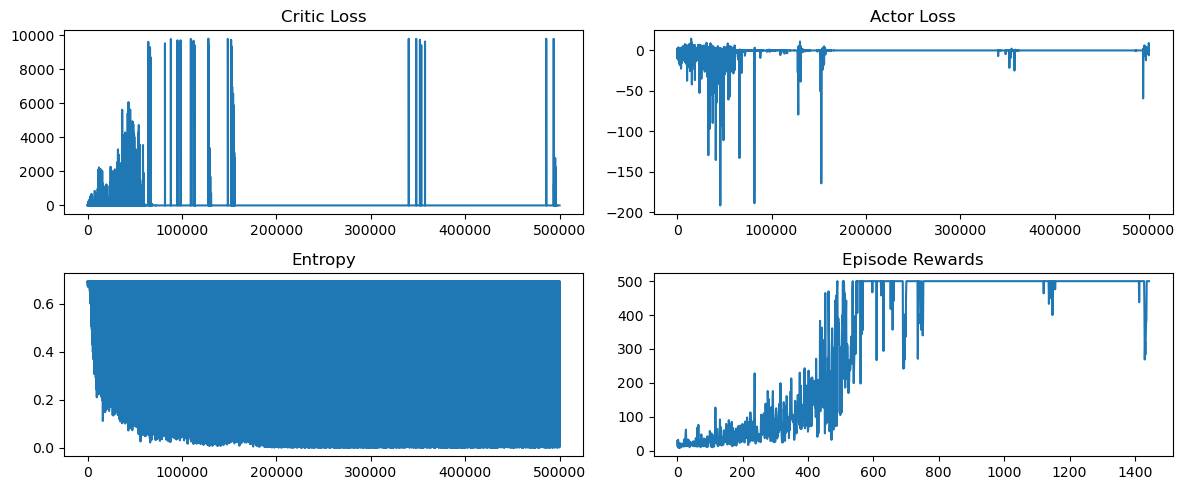

In [49]:
# CETTE RUN CETAIT APRES LES 500K steps
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
axs[0, 0].plot(critic_losses)
axs[0, 0].set_title('Critic Loss')
axs[0, 1].plot(actor_losses)
axs[0, 1].set_title('Actor Loss')
axs[1, 0].plot(entropies)
axs[1, 0].set_title('Entropy')
axs[1, 1].plot(ep_rewards)
axs[1, 1].set_title('Episode Rewards')
plt.tight_layout()
plt.show()


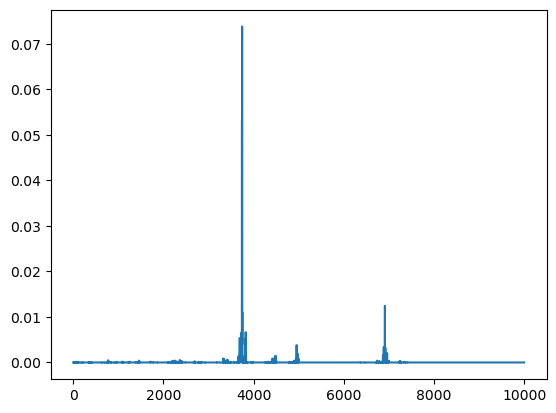

In [42]:
# PLOTTING

plt.plot(critic_losses)


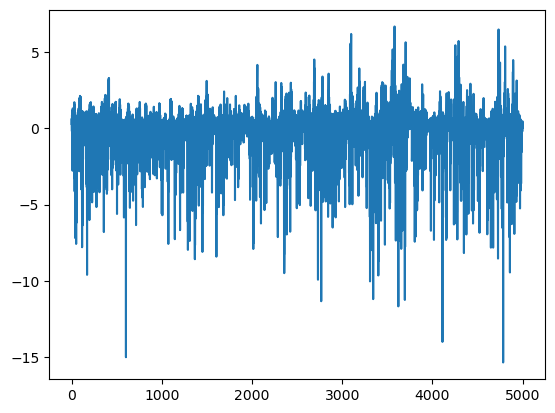

In [21]:
plt.plot(actor_losses)

In [22]:
steps_episodes

[41,
 56,
 107,
 125,
 172,
 217,
 252,
 280,
 310,
 354,
 426,
 461,
 504,
 550,
 584,
 603,
 647,
 688,
 728,
 766,
 791,
 840,
 882,
 923,
 953,
 989,
 1007,
 1052,
 1073,
 1131,
 1148,
 1167,
 1212,
 1244,
 1295,
 1326,
 1352,
 1376,
 1420,
 1463,
 1526,
 1576,
 1611,
 1659,
 1702,
 1741,
 1783,
 1832,
 1871,
 1986,
 2024,
 2100,
 2159,
 2199,
 2274,
 2290,
 2347,
 2364,
 2402,
 2465,
 2511,
 2557,
 2625,
 2660,
 2705,
 2751,
 2794,
 2831,
 2883,
 2903,
 2936,
 2994,
 3060,
 3218,
 3297,
 3316,
 3338,
 3355,
 3396,
 3414,
 3514,
 3610,
 3651,
 3692,
 3773,
 3827,
 3854,
 3911,
 3996,
 4037,
 4128,
 4199,
 4268,
 4327,
 4361,
 4438,
 4482,
 4515,
 4544,
 4623,
 4661,
 4685,
 4781,
 4831,
 4866,
 4954,
 4992]

In [17]:
len(ep_rewards)

180

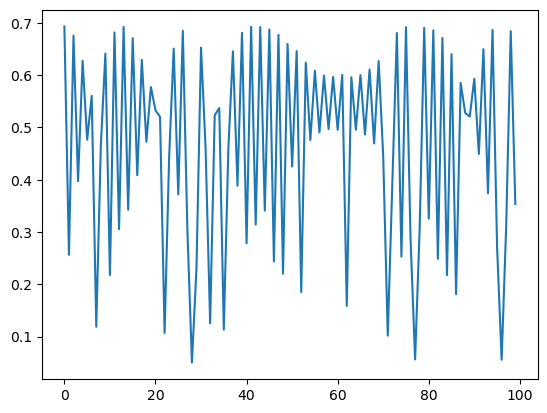

In [36]:
plt.plot(entropies[-100:])

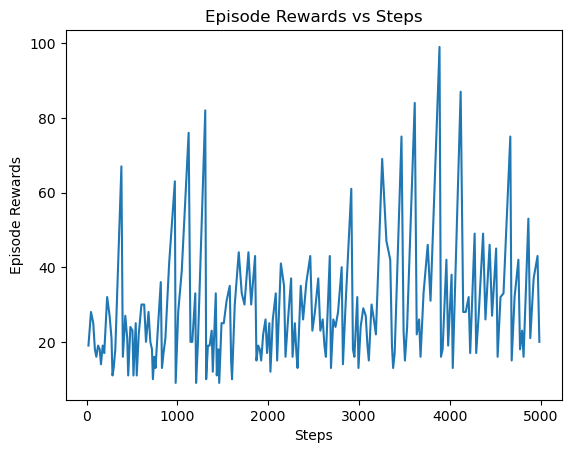

In [18]:
import matplotlib.pyplot as plt

# Assuming you have the following variables defined:
# ep_rewards: list of episode rewards
# steps_episodes: list of step counts at the end of each episode

# Plotting the data
plt.plot(steps_episodes, ep_rewards)
plt.xlabel('Steps')
plt.ylabel('Episode Rewards')
plt.title('Episode Rewards vs Steps')
plt.show()

# SHOWCASE

In [14]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state,bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.numpy())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 